# Feature Selection and Cost Analysis

## Introduction

This section includes an analysis of the different feature categories included in the data (e.g. Cognitive tests, Demographic factors, MRI). Whereas the previous section considered a range of different modeling methods this section focuses on understanding the relative strengths of the different feature categories. Firstly, the predictive performance of each feature category on its own is considered. Then a process is developed to fit a model with a selected subset of feature categories based on a trade off between several qualities of the category such as the medical cost, early detection capability and invasiveness versus the category's predictive performance.

In [1]:
# ====================
# Import libraries
# ====================

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Core
import numpy as np
import pandas as pd
import itertools
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import Image
from IPython.display import display

# skcikit-learn
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Helper functions (data processing, plots)
from utils.helpers import GridSearchPipe
from utils.helpers import get_model_data
from utils.helpers import plot_cv_results
from utils.helpers import plot_roc
from utils.helpers import plot_confusion_matrix
from utils.helpers import plot_important_features

In [23]:
# ====================
# Settings
# ====================

# IPython
%matplotlib inline

# Seaborn
sns.set()
sns.set_context("talk")
sns.set_style("white")
sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.5))
#sns.despine()

# Pandas
pd.set_option('precision', 4)

## Data processing

The same data processing steps used to create the baseline models are followed for this section. The only additional requirement was developing a process to efficiently subset the predictors of interest and not having to re-process (train/test split, imputation, etc.) the data for each model.

In [3]:
# ====================
# Import data
# ====================

# Read data
data = pd.read_csv('../data/data_all.csv', low_memory=False);

# Create 'year' variable
data['YEAR'] = data['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data = data.loc[(data['VISCODE'] == "bl") & (data['ORIGPROT'] == "ADNI1"), :]

# Import metadata file
meta = pd.read_csv('../data/metadata.csv')
        # NOTE: Exported to the fix to the 'Family history' to the csv
        #       so don't need to run that again.

# Cost assumptions
cost_assumptions = pd.read_csv('../data/cost_assumptions.csv')

# Merge metadata and cost assumptions
meta_data = meta.merge(cost_assumptions, on="cat")

In [4]:
# ===============
# Data processing
# ===============

# Response column name
response_col = "DX_bl"
class_names = ['CN','LMCI','AD']

# List of feature categories in data
cat_list = ['CSF',
            'Cognitive tests',
            'Cognitive tests (ADAS)',
            'Demographics',
            'Genetic markers', 
            'MRI measures',
            'MRI (Cross-sectional)',
            'PET measures']

# First drop predictors that have been excluded in metadata (e.g. _bl features)
meta = meta[meta.exclude == 0]

# Get list of features 
model_cols = list(meta[meta['cat'].isin(cat_list)]['column_name'])

# Model data processing
X_train, X_test, y_train, y_test, model_cols = get_model_data(data, response_col, model_cols)


A summary of the feature categories considered and the number of predictors per category is provided below:

In [5]:
df = meta[meta['cat'].isin(cat_list)]
df = pd.DataFrame(df.groupby('cat')['id'].count())
df.index.names = ['Feature Category']
df.columns=['Number of predictors']
df

,Number of predictors
Feature Category,
CSF,3
Cognitive tests,23
Cognitive tests (ADAS),13
Demographics,90
Genetic markers,3
MRI (Cross-sectional),346
MRI measures,7
PET measures,3


## Predictive performance from each feature category

Separate Gradient Boosted models are fit using only features from each of the categories displayed above. The parameters of the model are tuned using grid search with cross-validation. The ROC plots and corresponding AUC for each model are then compared to provide some insight into the relative predictive performance of each individual set of features (e.g. MRI vs Cognitive Tests). Feature importance plots are also created to provide a better understanding of the importance of individual features within each category as well.

The ROC curves below provide an indication of the predictive strength of each of the models. Separate ROC curves are created for each of the classes in the model (CN, LMCI, AD) as well as an average for all the classes. From the charts below we note the following:

* The Cognitive test features provides the best predictive performance, followed by the MRI measures. This is not unexpected given the relevance of these features in diagnosing Alzheimer's. However, we know that these features are only really effective in predicting Alzheimer's in the later stages of the disease progression. Thus, if we further increased the weight of importance for model's early disease detection capability, the best predictive performance is provided by CSF category instead.
* Of note, we removed the "CDRSB" cognitive test (Clinical Dementia Rating) from the Cognitive tests category for our model given we found this feature was likely a factor used to determining our chosen response "DX_bl", and thus we could not use this feature as a predictor
* The CSF, Genetic marker, MRI (Cross-sectional), and PET features can only really distinguish between CN and AD and do not provide useful information regarding LMCI diagnosis. 

In [6]:
# ==============================
# Fit individual category models
# ==============================

mod_results={}
for c in cat_list:
    
    # Subset features to train on
    cols = list(meta[meta.cat == c]['column_name'])
    msk = np.array([c in cols for c in model_cols])
    Xs_train = X_train[:,msk]
    Xs_test = X_test[:,msk]

    # Fit model
    est = GradientBoostingClassifier()
    params = {'learning_rate': [0.01, 0.05, 0.1, 0.2], 
              'n_estimators': [50, 100, 250],
              'max_depth': [3, 5]}
    gs = GridSearchCV(est, params, cv=5, n_jobs=4, verbose=0)
    gs.fit(Xs_train, y_train)
    
    mod_results[c] = {'gs': gs, 'X_train': Xs_train, 'X_test': Xs_test}

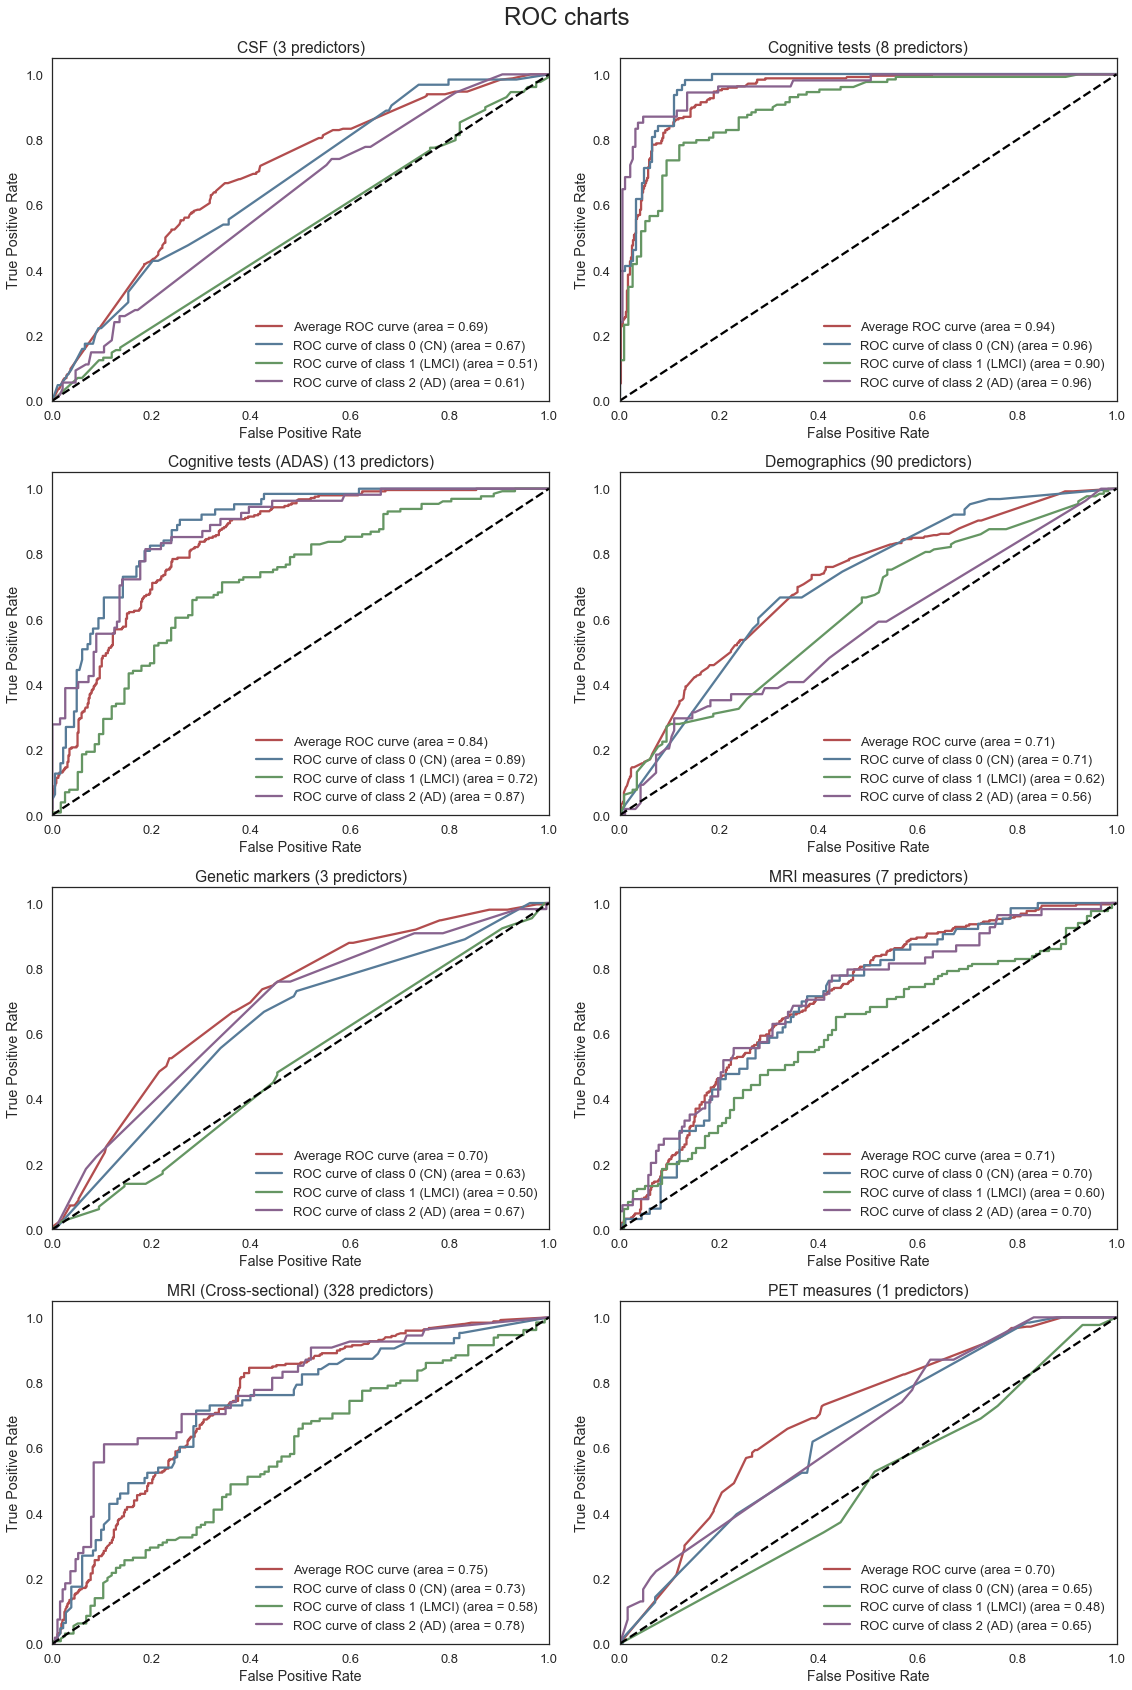

In [7]:
# ==============================
# Model diagnostics: ROC curves
# ==============================

fig, ax = plt.subplots(4, 2, figsize=(16, 24))
ax = ax.ravel()

i = 0
for mod in mod_results.values():
    
    # Get model
    gs = mod['gs']
    clf = gs.best_estimator_

    # Fit OvR classifier
    y = label_binarize(y_train, classes=class_names) 
    ovr = OneVsRestClassifier(clf)
    ovr.fit(mod['X_train'], y)  
    
    # Plot ROC curve
    text = " (" + str(clf.n_features_) + " predictors)"
    plot_roc(ovr, mod['X_test'], y_test, ax[i], title=cat_list[i] + text) 
    i = i + 1
    
plt.tight_layout()  
plt.suptitle("ROC charts", fontsize=24)
plt.subplots_adjust(top=0.95)
plt.show()    

The charts below provide some interesting insight into the relative importance of individual features within each category. In particular, we make the following observations:

**Cognitive tests:** The MMSE (Mini-Mental State Exam) appears to be the most important cognitive test, followed by FAQ (Functional Activities Questionnaire) and the ADAS (Alzheimer's Disease Assessment Scale) cognitive tests.

**Cognitive tests (ADAS):** Not all the ADAS questions appear to be equally important. Questions 1, 4 and 7 appear to be the most influential in the model. More detailed analysis on the individual questions are included in the next section of the report.

**Demographics:** Age and years of education are known risk factors. Interestingly, it appears that whether a person was a home-maker for most of their life and the age at which they retired also appears to be influential factors.

**Family history:** The most important factor is FHQMOMAD, which indicates whether the participant's mother was diagnosed with Alzheimer's disease (FHQPROV stands for family history questionnaire).

**Genetic markers:** APOE4 is the most important factor. Notably, APOE4 a protein which is a known risk factor of developing Alzheimer's disease found in previous academic studies.

**MRI measures:** Hippocampus volume showed to be the most important indicator. This is consistent with our observation from the EDA, where the volume of Hippocampus of a patient decreased from diagnosis as Cognitively Normal towards Alzheimer's disease.

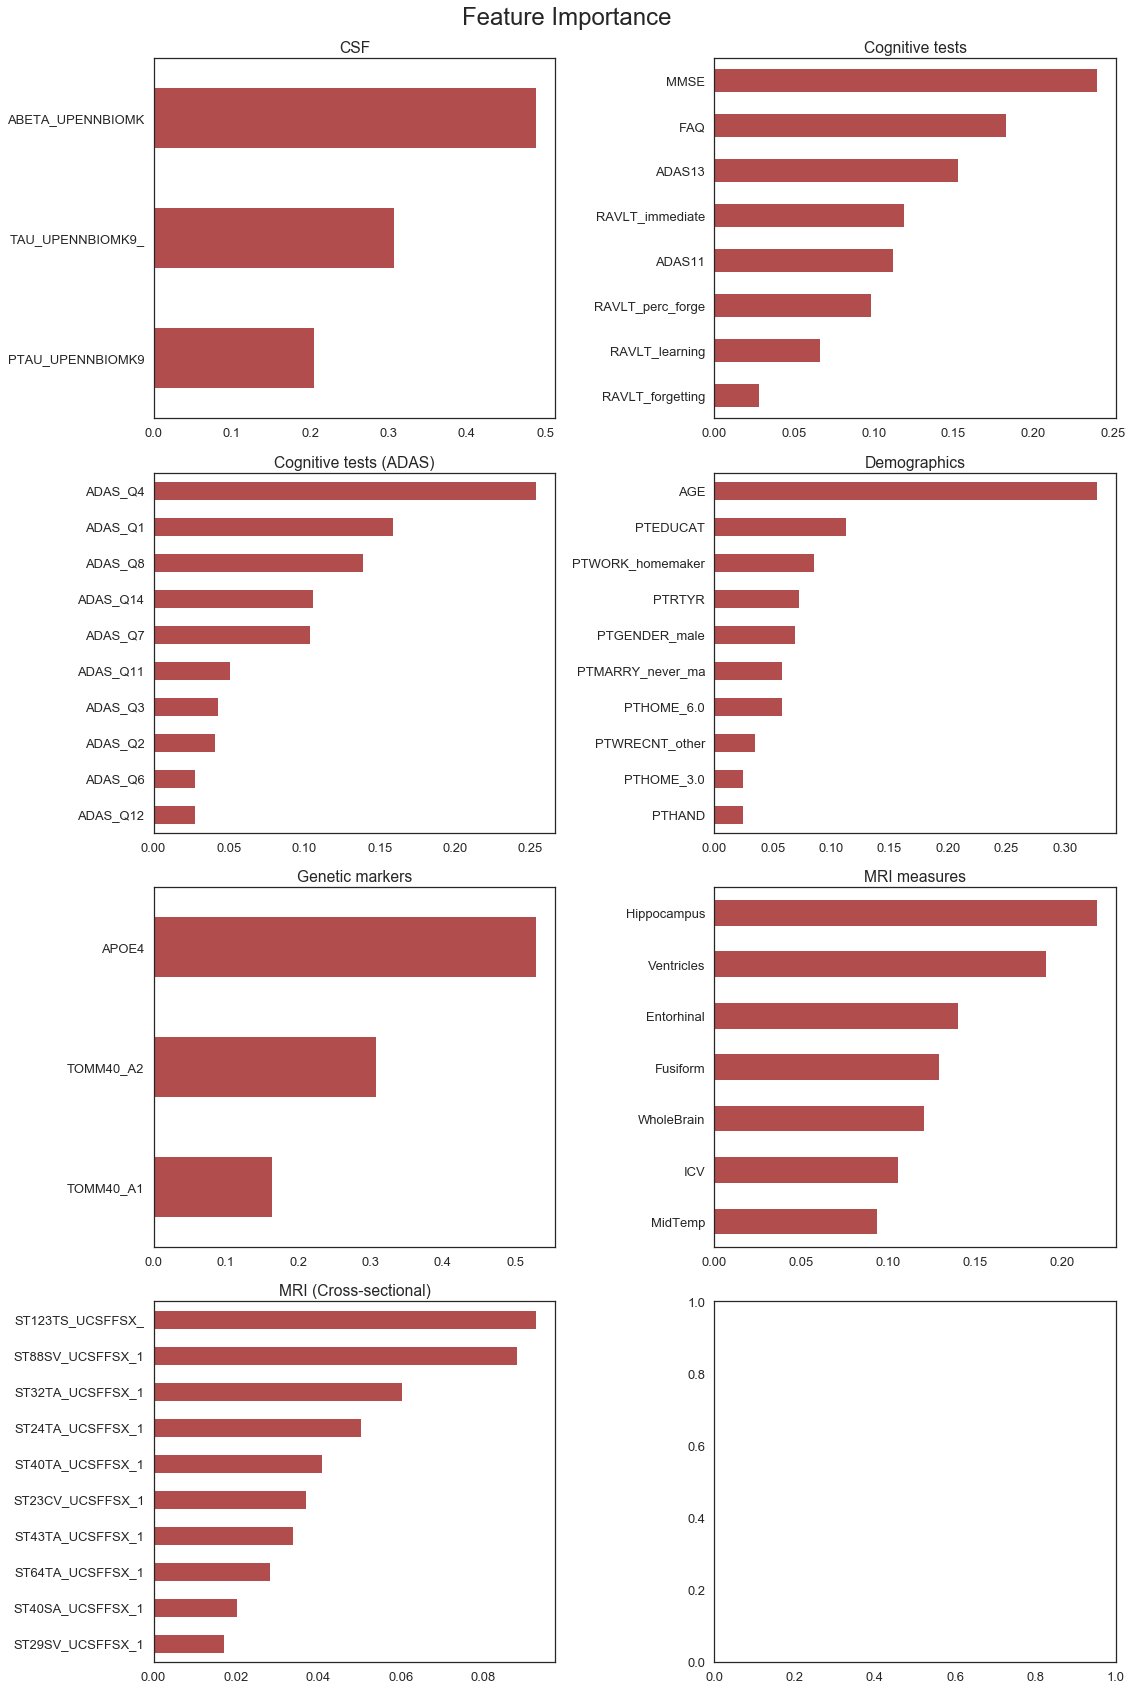

In [8]:
# =====================================
# Model diagnostics: Feature importance
# =====================================

fig, ax = plt.subplots(4, 2, figsize=(16, 24))
ax = ax.ravel()
top_n = 10

i = 0
for mod in mod_results.values():
    
    # Get model
    gs = mod['gs'] 
    clf = gs.best_estimator_
    importance = clf.feature_importances_

    # Feature names
    c = cat_list[i]
    cols = list(meta[meta.cat == c]['column_name'])
    feature_names = [c for c in model_cols if c in cols]
    
    if len(importance) > 1:
        df = pd.DataFrame(importance)
        df.index = [s[:16] for s in feature_names]
        df.columns = ["FeatureImportance"]
        df.sort_values(by="FeatureImportance", ascending=True, inplace=True)
        df = df[-top_n:]
        df.plot(kind='barh', ax=ax[i], legend=False)
        
        title = cat_list[i]
        ax[i].set_title(title)
        i = i + 1
    
plt.tight_layout()  
plt.suptitle("Feature Importance", fontsize=24)
plt.subplots_adjust(top=0.95)
plt.show()    

## Cost assumptions by feature category

Each of the feature categories has different characteristics with regard to predictive performance, as demonstrated in the previous section, but also with regard to medical cost, early detection ability and invasiveness of procedure to collect the data. 

**Cognitive tests:** Cognitive tests are important in Alzheimer's disease because they measure cognitive decline in a direct and quantifiable manner. However, these tests also have several limitations in that they suffer from practice effects and patients who undertake the same test several times can obtain inflated scores. The tests are also not very useful for early detection.

**CSF measures:** Abnormal levels of amyloid-beta and tau/p-tau protein concentrations in the cerebrospinal fluid (CSF) are some of the earliest signs of Alzheimer's disease and can indicate abnormalities many years before symptoms onset. As such, these tests could be very valuable for early detection. However, in order to collect the fluid a lumbar puncture needs to be performed, which is highly invasive.

**Demographics / Family history:** Known risk factors include age, gender and eduction. Demographic factors are easy to collect and non-invasive, but can lack sufficient predictive power.

**Genetic Markers**: Collection of genetic markers for genotyping only requires a small sample of blood, with medium cost for laboratory analysis work. It is known that the protein APOE4 is a known risk factor.

**Family History**: The precedent of Alzheimer's disease incidence in patient's relatives could be a cost-effective decision factor for further early diagnosis testing when a patient lacks other symptoms.

**MRI / PET measures:** Quantification of atrophy and molecullar processes in the brain with MRI and PET scans are very important biomarkers as these tests are widely available and non-invasive. Of note, MRI scans are relatively cheaper than PET.

In [9]:
# ====================================
# Setup cost assumptions - Scenario 1
# ====================================

# Input weights by cost category (medical, early detection, invasiveness)
weights = [0.1, 5, 0.2]

# Calculate weighted costs
cost = cost_assumptions[cost_assumptions.cat.isin(cat_list)]
cost.columns = ['Feature Category'] + [c + " (w=" + str(w) + ")" for c, w in zip(list(cost.columns)[1:], weights)] 
cost.index = cost['Feature Category']
cost = cost.iloc[:,1:]
cost['WeightedCost'] = cost.apply(lambda row: np.dot(row, weights), axis=1)
cost

,MedicalCost (w=0.1),EarlyDetection (w=5),Invasiveness (w=0.2),WeightedCost
Feature Category,,,,
Cognitive tests,3,8,3,40.9
Cognitive tests (ADAS),3,8,3,40.9
CSF,5,3,8,17.1
Demographics,5,5,2,25.9
Genetic markers,4,5,3,26.0
MRI (Cross-sectional),5,4,6,21.7
MRI measures,5,4,6,21.7
PET measures,7,3,6,16.9


The table above includes some subjective cost assumptions by category for the different cost considerations outlined above. The assigned values are on a 10-point scale (0-9) and have been combined using a weighting approach to provide a 'weighted cost' measure. 

No formal research has been conducted to obtain the cost assumptions. The intention is to provide a framework that subject matter experts can use to include more subjective considerations that would influence the set of features included in the final model. 

For example, if **early detection** is really important, then a large weight could be allocated to that component (See Scenario 2). As a result,  models with features that are not perceived to be useful for early detection (e.g. Cognitive tests) would be penalized more even though the model accuracy might be lower and the ones contributing (e.g., CSF, PET) will be penalized less. 

Similarly, if we assign a large weight to the **medical cost** (see Scenario 3), perhaps when a cost-sensitive clinician wants to make a data-driven decision on the diagnostic tests, the model will preferentially select lower-cost categories first, such as Cognitive tests, which is a trade-off for early detection model capacity.

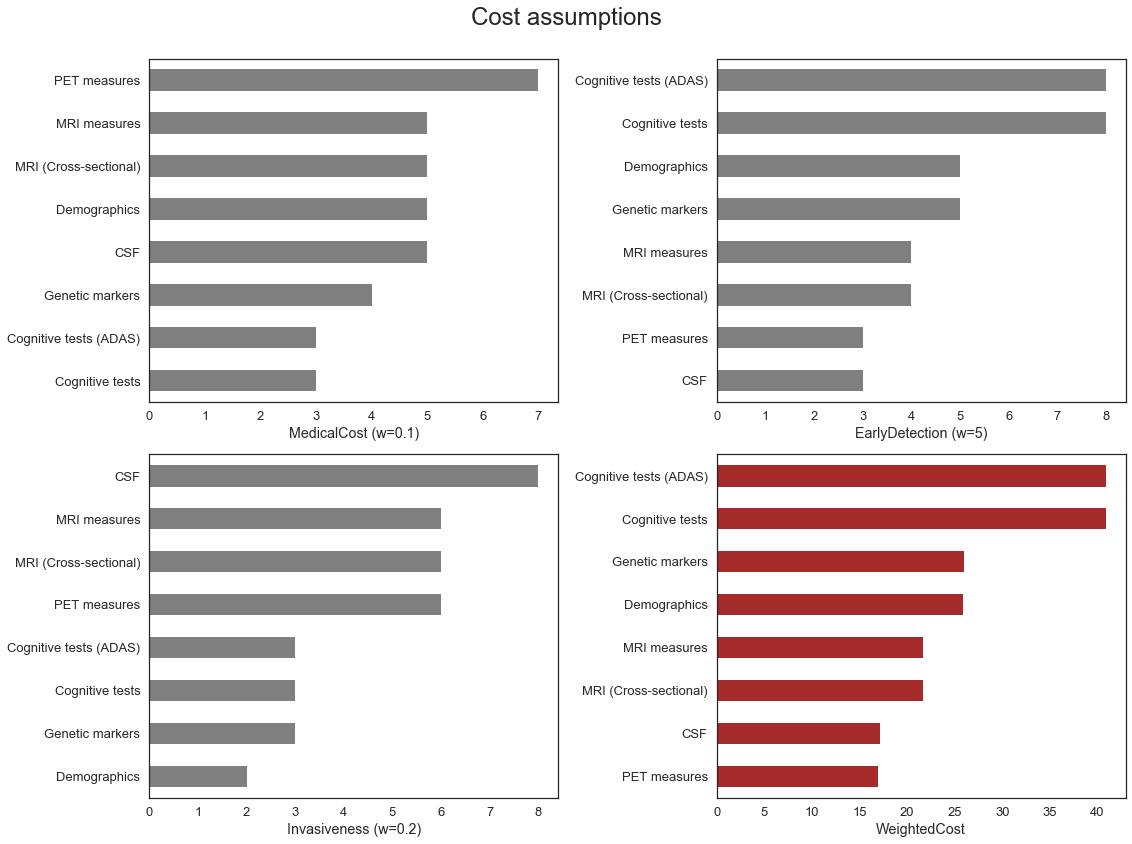

In [10]:
# Summary of cost assumptions
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.ravel()

cost_cols = list(cost.columns)
for c in cost_cols:
    i = cost_cols.index(c)
    cost.sort_values(c, inplace=True)
    col ='brown' if i == 3 else 'grey'
    cost[c].plot(kind='barh', color=col, ax = ax[i])
    ax[i].set_xlabel(c)
    ax[i].set_ylabel("")

plt.tight_layout()  
plt.suptitle("Cost assumptions", fontsize=24)
plt.subplots_adjust(top=0.92)
plt.show()   

## Forward stepwise process to select cost efficient feature sets

This section outlines a forward stepwise selection process, which was developed to select feature categories to include in a model. The process starts with a null  model and then sequentially adds the feature category that maximizes a performance/cost measure based on both the accuracy of the model and the cost of the feature category used in the model. The ‘best’ set of features is added at each step until all the features have been added. At each step the accuracy, cost and ‘score’ (based on accuracy and cost) are measured. The output can therefore be used to find the best subset of features for a required level of accuracy or maximum allowed cost.

In [11]:
# ======================================================================
# Cost analysis through forward stepwise feature selection (Scenario 1)
# ======================================================================

# NOTE: Takes about an hour to run with current Gridsearch, CV params

# Input params (cost coefficient)
# NOTE: This is a scaling parameter to put accuracy scores and 
#       cost measures on the same scale

def forward_stepwise_selection(cat_list, meta, cost, model_cols, X_train, X_test):

    verbose = 0
    K = 0.01
    exclude_vars = ['MMSE']

    # Initialize variables
    step_scores = []
    step_accuracy = []
    step_cost = []
    step_categories = []
    step_models = []

    categories = set(cat_list)
    selected_categories = set()
    total_cost = 0
    count = 0

    # Forward stepwise process (by feature category)
    while (True):

        possible_scores = []
        possible_accuracy = []
        possible_models = []
        possible_categories = list(selected_categories ^ categories)
        count += 1

        if len(possible_categories) == 0:
            break

        for cat in possible_categories:

            # Get predictor names within category
            cols = list(meta[meta.cat == cat]['column_name'])
            msk = np.array([(c in cols) & (c not in exclude_vars) for c in model_cols])

            # Training data
            if len(selected_categories) == 0: 
                xtrain = X_train[:,msk]
            else:
                xtrain = np.concatenate([X_forward_train, X_train[:,msk]], axis=1)

            # Fit model
            est = GradientBoostingClassifier()
            params = {'learning_rate': [0.01, 0.05, 0.1], 
                      'n_estimators': [200],
                      'max_depth': [3, 5],
                      'subsample': [1],
                      'max_features': [None]}
            gs = GridSearchCV(est, params, cv=5, n_jobs=-1, verbose=0)
            gs.fit(xtrain, y_train) 
            possible_models.append(gs)

            # Accuracy
            accuracy = gs.best_score_
            possible_accuracy.append(accuracy)

            # Cost / Score
            wcost = cost.loc[cat, "WeightedCost"] * K
            score = accuracy - (total_cost + wcost)
            possible_scores.append(score)

        # Get best category based on score
        best_category_idx = np.argmax(possible_scores)
        best_category = possible_categories[best_category_idx]

        # Get validation accuracy for selected category
        accuracy = possible_accuracy[best_category_idx]

        # Score (accuracy-cost) 
        best_score = np.max(possible_scores)
        step_scores.append(best_score)

        # Cost for selected category
        total_cost += cost.loc[best_category, "WeightedCost"] * K
        step_cost.append(total_cost)

        # Update data for next iteration
        best_cols = list(meta[meta.cat == best_category]['column_name'])
        msk = np.array([(c in best_cols) & (c not in exclude_vars) for c in model_cols])
        if len(selected_categories) == 0:
            X_forward_train = X_train[:,msk]
            X_forward_test = X_test[:,msk]
        else:
            X_forward_train = np.concatenate([X_forward_train, X_train[:,msk]], axis=1)
            X_forward_test = np.concatenate([X_forward_test, X_test[:,msk]], axis=1)

        # Get test accuracy
        best_model = possible_models[best_category_idx]
        clf = best_model.best_estimator_
        test_accuracy = clf.score(X_forward_test, y_test)
        step_accuracy.append([accuracy, test_accuracy])

        selected_categories.add(best_category)
        step_categories.append(list(selected_categories))

        if verbose == 1:
            print("\nBest category = " + best_category)
            print("Selected categories: " + str(selected_categories))
            print("Validation accuracy: {0:.4f}".format(accuracy))
            print("Test accuracy: {0:.4f}".format(test_accuracy))
            print("Total cost: {0:.2f}".format(total_cost))
            print("="*30 +"\n")
        
    results = []
    results.append(step_categories)
    results.append(step_accuracy)
    results.append(step_cost)
    results.append(step_scores)
        
    return results

### Scenario 1: Baseline

The table below summarizes the order in which feature categories were added to the model and the relevant accuracy and cost measures at each stage.

In [12]:
# Run scenario 1
step_categories, step_accuracy, step_cost, step_scores = \
        forward_stepwise_selection(cat_list, meta, cost, model_cols, X_train, X_test)

In [13]:
# Scenario 1 (Results summary)
temp = []
best_index = []
for selected_categories in step_categories:
    best = [c for c in selected_categories if c not in temp]
    best_index.append("+ " + str(best[0]))
    temp = selected_categories

df = pd.DataFrame(step_accuracy)
df.columns = ['ValidationAccuracy', 'TestAccuracy']
df['CostMeasure'] = step_cost
df['Score'] = step_scores
df.index = best_index
df

,ValidationAccuracy,TestAccuracy,CostMeasure,Score
+ Cognitive tests,0.7592,0.7967,0.409,0.3502
+ PET measures,0.7557,0.7927,0.578,0.1777
+ CSF,0.7539,0.8049,0.749,0.0049
+ MRI (Cross-sectional),0.7609,0.8049,0.966,-0.2051
+ MRI measures,0.7627,0.7927,1.183,-0.4203
+ Demographics,0.7644,0.8008,1.442,-0.6776
+ Genetic markers,0.7679,0.7967,1.702,-0.9341
+ Cognitive tests (ADAS),0.7661,0.8089,2.111,-1.3449


The charts below shows that cost-adjusted accuracy as well as the total cost at each stage of the process. The cost-adjusted accuracy is somewhat variable between steps, but still provides useful information about the optimal set of features for the given cost assumptions. In the chart below the optimal set of features (i.e. where the cost-adjusted accuracy is maximized) includes the following feature categories: Cognitive tests, PET measures, CSF and MRI.

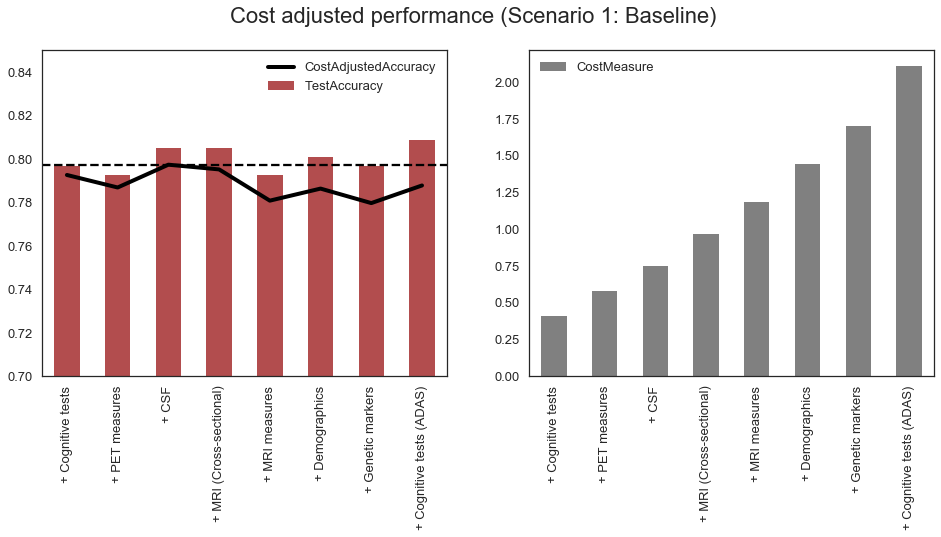

In [14]:
# Scenario 1 (Plots)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

df.plot(y=["TestAccuracy"], kind="bar", ylim=(0.7, 0.85), ax=ax[0])
c = df["TestAccuracy"].values - (df["CostMeasure"].values*0.01)
ax[0].plot(c, color="black", label="CostAdjustedAccuracy", linewidth=4)
ax[0].axhline(y=np.max(c), color='black', linestyle='--')
ax[0].legend()

df.plot(y=["CostMeasure"], kind="bar", ax=ax[1], color="grey")
plt.suptitle("Cost adjusted performance (Scenario 1: Baseline)", fontsize=22)
plt.subplots_adjust(top=0.88)
plt.show()  

### Scenario 2: High importance of early detection

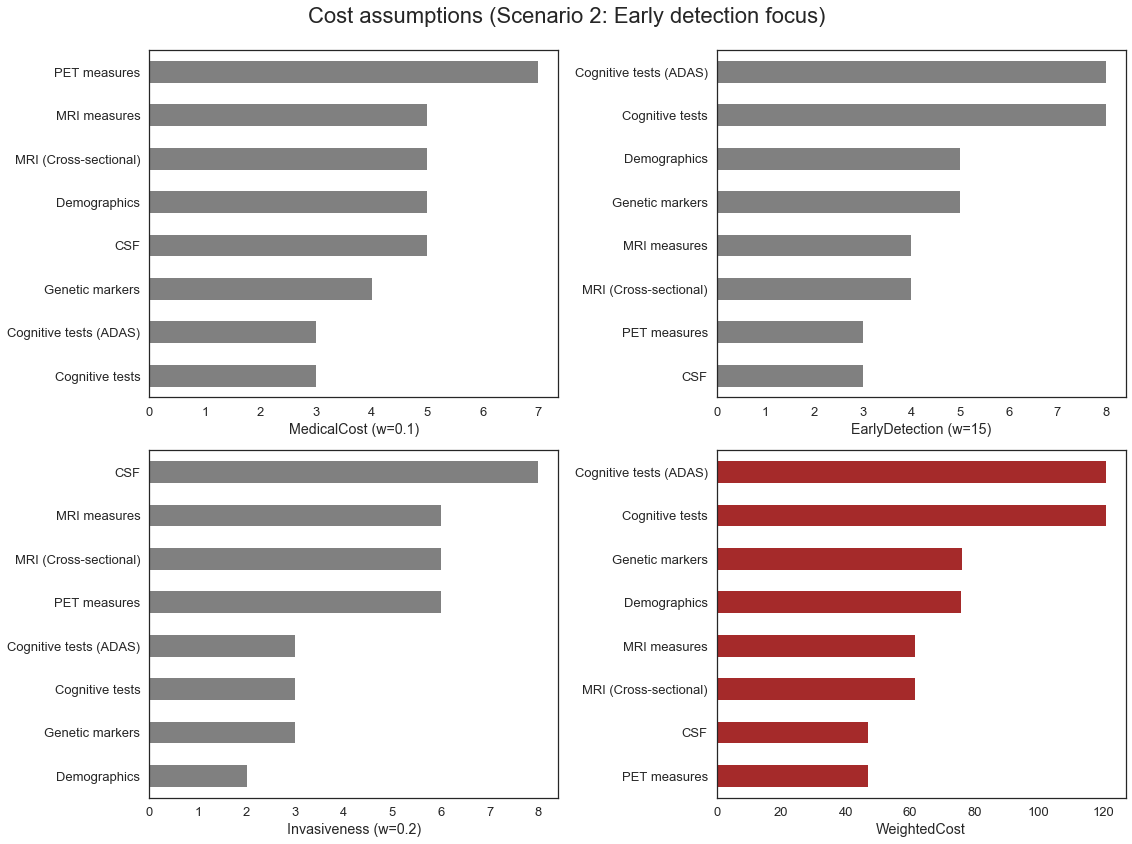

In [15]:
# ====================================
# Setup cost assumptions - Scenario 2
# ====================================

# Input weights by cost category (medical, early detection, invasiveness)
weights = [0.1, 15, 0.2]

# Calculate weighted costs
cost = cost_assumptions[cost_assumptions.cat.isin(cat_list)]
cost.columns = ['Feature Category'] + [c + " (w=" + str(w) + ")" for c, w in zip(list(cost.columns)[1:], weights)] 
cost.index = cost['Feature Category']
cost = cost.iloc[:,1:]
cost['WeightedCost'] = cost.apply(lambda row: np.dot(row, weights), axis=1)

# Summary of cost assumptions
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.ravel()

cost_cols = list(cost.columns)
for c in cost_cols:
    i = cost_cols.index(c)
    cost.sort_values(c, inplace=True)
    col ='brown' if i == 3 else 'grey'
    cost[c].plot(kind='barh', color=col, ax = ax[i])
    ax[i].set_xlabel(c)
    ax[i].set_ylabel("")

plt.tight_layout()  
plt.suptitle("Cost assumptions (Scenario 2: Early detection focus)", fontsize=22)
plt.subplots_adjust(top=0.93)
plt.show() 

In [16]:
# Run scenario 2
step_categories, step_accuracy, step_cost, step_scores = \
        forward_stepwise_selection(cat_list, meta, cost, model_cols, X_train, X_test)

In [17]:
# Scenario 2 (Results summary)
temp = []
best_index = []
for selected_categories in step_categories:
    best = [c for c in selected_categories if c not in temp]
    best_index.append("+ " + str(best[0]))
    temp = selected_categories

df = pd.DataFrame(step_accuracy)
df.columns = ['ValidationAccuracy', 'TestAccuracy']
df['CostMeasure'] = step_cost
df['Score'] = step_scores
df.index = best_index
df

,ValidationAccuracy,TestAccuracy,CostMeasure,Score
+ CSF,0.4974,0.4919,0.471,0.0264
+ PET measures,0.5061,0.4837,0.940,-0.4339
+ MRI measures,0.5497,0.5447,1.557,-1.0073
+ MRI (Cross-sectional),0.5393,0.5447,2.174,-1.6347
+ Demographics,0.5777,0.6179,2.933,-2.3553
+ Genetic markers,0.5829,0.5894,3.693,-3.1101
+ Cognitive tests,0.7679,0.8049,4.902,-4.1341
+ Cognitive tests (ADAS),0.7679,0.8089,6.111,-5.3431


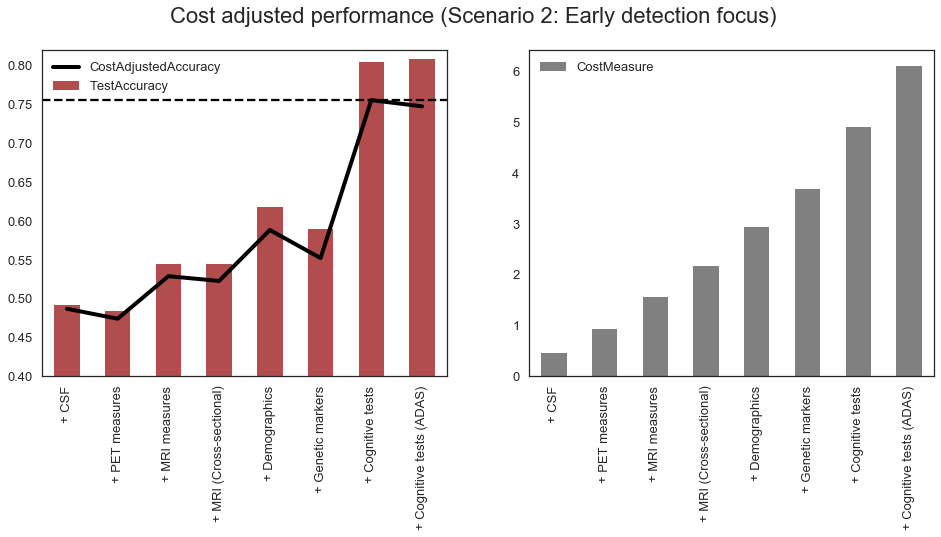

In [18]:
# Scenario 2 (Plots)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

df.plot(y=["TestAccuracy"], kind="bar", ylim=(0.4, 0.82), ax=ax[0])
c = df["TestAccuracy"].values - (df["CostMeasure"].values*0.01)
ax[0].plot(c, color="black", label="CostAdjustedAccuracy", linewidth=4)
ax[0].axhline(y=np.max(c), color='black', linestyle='--')
ax[0].legend()

df.plot(y=["CostMeasure"], kind="bar", ax=ax[1], color="grey")
plt.suptitle("Cost adjusted performance (Scenario 2: Early detection focus)", fontsize=22)
plt.subplots_adjust(top=0.88)
plt.show() 

From above, we can see that when assigning high weight to the early detection cost, the methods more suitable for early detection are selected first based on the cost/accuracy score, such as CSF and PET, despite lower overall accuracy. On the other hand, the cognitive tests, despite having high accuracy, are selected the last because they contribute the least to the early detection power of our model.

### Scenario 3: Medical cost priority

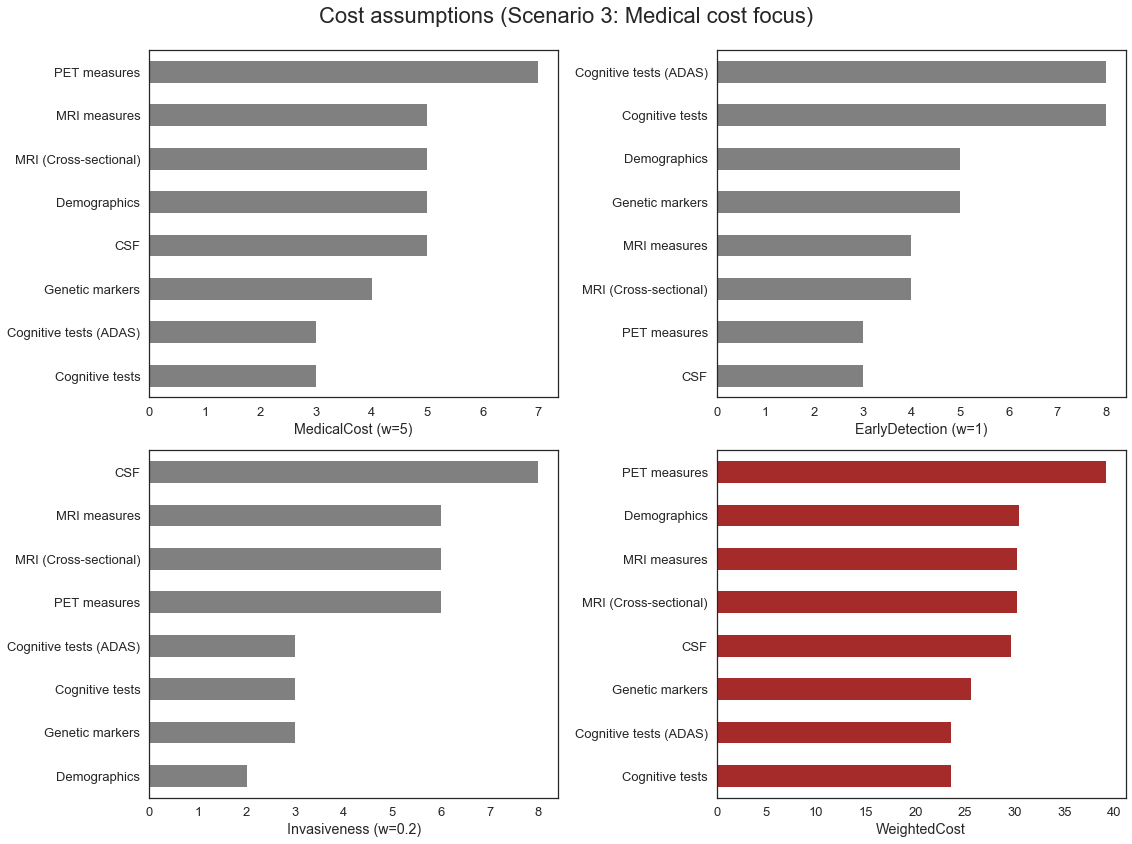

In [19]:
# ====================================
# Setup cost assumptions - Scenario 3
# ====================================

# Input weights by cost category (medical, early detection, invasiveness)
weights = [5, 1, 0.2]

# Calculate weighted costs
cost = cost_assumptions[cost_assumptions.cat.isin(cat_list)]
cost.columns = ['Feature Category'] + [c + " (w=" + str(w) + ")" for c, w in zip(list(cost.columns)[1:], weights)] 
cost.index = cost['Feature Category']
cost = cost.iloc[:,1:]
cost['WeightedCost'] = cost.apply(lambda row: np.dot(row, weights), axis=1)

# Summary of cost assumptions
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.ravel()

cost_cols = list(cost.columns)
for c in cost_cols:
    i = cost_cols.index(c)
    cost.sort_values(c, inplace=True)
    col ='brown' if i == 3 else 'grey'
    cost[c].plot(kind='barh', color=col, ax = ax[i])
    ax[i].set_xlabel(c)
    ax[i].set_ylabel("")

plt.tight_layout()  
plt.suptitle("Cost assumptions (Scenario 3: Medical cost focus)", fontsize=22)
plt.subplots_adjust(top=0.93)
plt.show() 

In [20]:
# Run scenario 3
step_categories, step_accuracy, step_cost, step_scores = \
        forward_stepwise_selection(cat_list, meta, cost, model_cols, X_train, X_test)

In [21]:
# Scenario 3 (Results summary)
temp = []
best_index = []
for selected_categories in step_categories:
    best = [c for c in selected_categories if c not in temp]
    best_index.append("+ " + str(best[0]))
    temp = selected_categories

df = pd.DataFrame(step_accuracy)
df.columns = ['ValidationAccuracy', 'TestAccuracy']
df['CostMeasure'] = step_cost
df['Score'] = step_scores
df.index = best_index
df

,ValidationAccuracy,TestAccuracy,CostMeasure,Score
+ Cognitive tests,0.7592,0.7967,0.236,0.5232
+ Cognitive tests (ADAS),0.7487,0.7398,0.472,0.2767
+ Genetic markers,0.7435,0.7846,0.728,0.0155
+ MRI measures,0.7714,0.7764,1.030,-0.2586
+ CSF,0.7679,0.7805,1.326,-0.5581
+ Demographics,0.7661,0.7927,1.630,-0.8639
+ MRI (Cross-sectional),0.7696,0.8089,1.932,-1.1624
+ PET measures,0.7661,0.8252,2.324,-1.5579


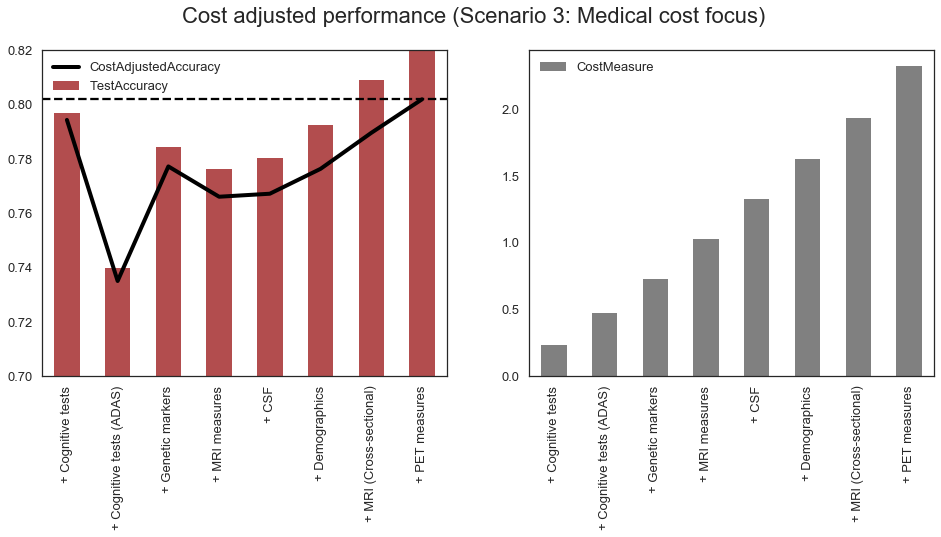

In [22]:
# Scenario 3 (Plots)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()

df.plot(y=["TestAccuracy"], kind="bar", ylim=(0.7, 0.82), ax=ax[0])
c = df["TestAccuracy"].values - (df["CostMeasure"].values*0.01)
ax[0].plot(c, color="black", label="CostAdjustedAccuracy", linewidth=4)
ax[0].axhline(y=np.max(c), color='black', linestyle='--')
ax[0].legend()

df.plot(y=["CostMeasure"], kind="bar", ax=ax[1], color="grey")
plt.suptitle("Cost adjusted performance (Scenario 3: Medical cost focus)", fontsize=22)
plt.subplots_adjust(top=0.88)
plt.show() 

We can see that if the weight on the Medical Cost is high enough, our model will preferentially choose "cheaper" categories first, and the most expensive ones, such as PET, later, in spite of increased accuracy with PET category in our model.